visualize

# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [4]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

In [5]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [6]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX') #한국 주가 정보 가져오기
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [60]:
df = fdr.DataReader('005380','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [63]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,121000,121000,118000,118000,556532,-0.020747
2020-01-03,118500,119000,115000,116000,1145187,-0.016949
2020-01-06,116000,117000,115500,116000,334574,0.000000
2020-01-07,116500,117000,115500,115500,674196,-0.004310
2020-01-08,115000,115500,111500,112000,1044825,-0.030303
...,...,...,...,...,...,...
2022-04-06,177000,182000,176500,180000,641803,0.005587
2022-04-07,180000,182000,178500,178500,778374,-0.008333
2022-04-08,178000,179000,175500,176500,458780,-0.011204


In [64]:
df = df.fillna(0) # 값이 없는거 그냥 0으로 채우기

No handles with labels found to put in legend.


(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

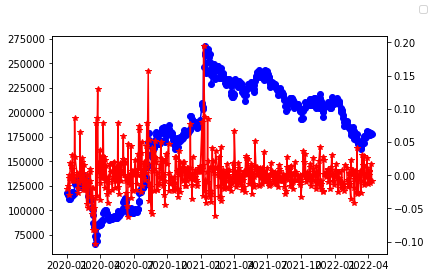

In [65]:
fig, ax1 = plt.subplots()
ax1.plot(df['Close'], 'bo-')
ax2 = ax1.twinx()
ax2.plot(df['Change'], 'r*-')
fig.legend(loc="upper right")
plt.xticks(rotation=45)


현대차, 기아, 한국우주항공

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [66]:
import os
import sys
import urllib.request
client_id = "qzIQMEBIvbTVu7zhgl2m"
client_secret = "rgOrkg84Iu"

In [67]:
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"현대차\",\"keywords\":[\"현대차\",\"Hyunadi\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"m\"}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [68]:
search_count_json = json.loads(search_count)

In [69]:
df_json = pd.DataFrame(search_count_json["results"][0]["data"])

In [70]:
df_json

,period,ratio
0,2020-01-01,0.7926
1,2020-01-02,0.3963
2,2020-01-03,0.2642
3,2020-01-04,0.1321
4,2020-01-05,0.3963
...,...,...
826,2022-04-08,2.1136
827,2022-04-09,0.5284
828,2022-04-10,1.3210
829,2022-04-11,2.2457


## 1-3. 데이터 전처리 및 Merge하기

In [71]:
df_json.columns = ['Date', 'Count']

In [72]:
df_json['Date'] = pd.to_datetime(df_json['Date'])

In [73]:
df_json

,Date,Count
0,2020-01-01,0.7926
1,2020-01-02,0.3963
2,2020-01-03,0.2642
3,2020-01-04,0.1321
4,2020-01-05,0.3963
...,...,...
826,2022-04-08,2.1136
827,2022-04-09,0.5284
828,2022-04-10,1.3210
829,2022-04-11,2.2457


In [74]:
df_json.reset_index(drop=True)
df_json.set_index("Date")

,Count
Date,
2020-01-01,0.7926
2020-01-02,0.3963
2020-01-03,0.2642
2020-01-04,0.1321
2020-01-05,0.3963
...,...
2022-04-08,2.1136
2022-04-09,0.5284
2022-04-10,1.3210


In [75]:
#Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
df_all = pd.merge_asof(df, df_json, on="Date", by="Date")

In [76]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Count
0,2020-01-02,121000,121000,118000,118000,556532,-0.020747,0.3963
1,2020-01-03,118500,119000,115000,116000,1145187,-0.016949,0.2642
2,2020-01-06,116000,117000,115500,116000,334574,0.000000,0.3963
3,2020-01-07,116500,117000,115500,115500,674196,-0.004310,0.2642
4,2020-01-08,115000,115500,111500,112000,1044825,-0.030303,NaN
...,...,...,...,...,...,...,...,...
558,2022-04-06,177000,182000,176500,180000,641803,0.005587,0.7926
559,2022-04-07,180000,182000,178500,178500,778374,-0.008333,1.7173
560,2022-04-08,178000,179000,175500,176500,458780,-0.011204,2.1136
561,2022-04-11,176000,181000,175500,179500,641674,0.016997,2.2457


No handles with labels found to put in legend.


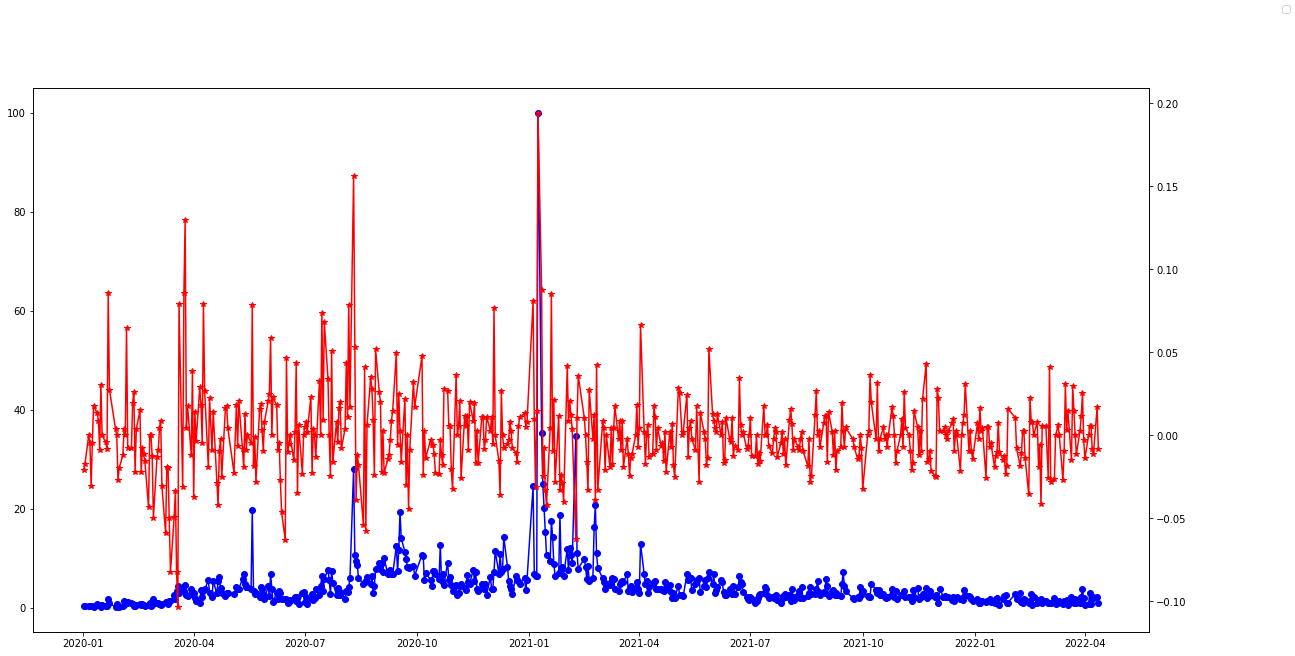

In [88]:
## You need to visualized a relational graph
# plt.figure(figsize=(20,10))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(df_all['Date'], df_all['Count'], 'bo-')
ax2 = ax1.twinx()
ax2.plot(df_all['Date'], df_all['Change'], 'r*-')
fig.legend(loc="upper right")
# plt.xticks(rotation=45)

In [89]:
df_all.any().isnull()

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
Change    False
Count     False
dtype: bool

In [23]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

# 2. Define Model

In [26]:
class LinearModel(torch.nn.Module): # 교수님 모델 새로 추가로 내용 더 넣어서 생성
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        print("inX:" ,x)
        print("inSquee",x.unsqueeze(0))
        x = self.linear_classifier(x.unsqueeze(0))
        print("outX:" ,x)
        return x

# 3. Define the loss function and the optimizer

In [92]:
input_dim = 1
output_dim = 1
learning_rate = 0.01
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [93]:
def train(train_x, train_y, loss_function, optimizer, model):

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    print(idx)
    print(train_x[idx])
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    print("the value of logit", logit)
    loss = loss_function(logit, train_y_tensor)
    print("the value of loss", loss)

    loss.backward()
    optimizer.step()

  return ""

# 5. Training 

NAN 값은 너무 값이 커서 backpropagation 하기 힘들어서 발생하는 문제

따라서 넣을 때 그냥 넣지 말고 정규화를 해서 넣으면 된다.

In [97]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_all[:] = scaler.fit_transform(df_all[:])

TypeError: ignored

In [94]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_all["Count"].to_numpy(),df_all["Change"].to_numpy(), test_size=0.2)

In [95]:
best_model = None
best_model = train(train_x, train_y, loss_function, optimizer, model)

0
2.642
inX: tensor(2.6420)
inSquee tensor([2.6420])
outX: tensor([-0.7494], grad_fn=<AddBackward0>)
the value of logit tensor([-0.7494], grad_fn=<AddBackward0>)
the value of loss tensor(0.5616, grad_fn=<MseLossBackward0>)
1
2.2457
inX: tensor(2.2457)
inSquee tensor([2.2457])
outX: tensor([-0.4929], grad_fn=<AddBackward0>)
the value of logit tensor([-0.4929], grad_fn=<AddBackward0>)
the value of loss tensor(0.2576, grad_fn=<MseLossBackward0>)
2
11.49273
inX: tensor(11.4927)
inSquee tensor([11.4927])
outX: tensor([-3.4161], grad_fn=<AddBackward0>)
the value of logit tensor([-3.4161], grad_fn=<AddBackward0>)
the value of loss tensor(11.6698, grad_fn=<MseLossBackward0>)
3
2.9062
inX: tensor(2.9062)
inSquee tensor([2.9062])
outX: tensor([1.7056], grad_fn=<AddBackward0>)
the value of logit tensor([1.7056], grad_fn=<AddBackward0>)
the value of loss tensor(2.9815, grad_fn=<MseLossBackward0>)
4
0.7926
inX: tensor(0.7926)
inSquee tensor([0.7926])
outX: tensor([0.6141], grad_fn=<AddBackward0>)
t

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 tensor([1.0186], grad_fn=<AddBackward0>)
the value of loss tensor(1.0146, grad_fn=<MseLossBackward0>)
30
1.321
inX: tensor(1.3210)
inSquee tensor([1.3210])
outX: tensor([0.2539], grad_fn=<AddBackward0>)
the value of logit tensor([0.2539], grad_fn=<AddBackward0>)
the value of loss tensor(0.0694, grad_fn=<MseLossBackward0>)
31
10.03963
inX: tensor(10.0396)
inSquee tensor([10.0396])
outX: tensor([0.9122], grad_fn=<AddBackward0>)
the value of logit tensor([0.9122], grad_fn=<AddBackward0>)
the value of loss tensor(0.8739, grad_fn=<MseLossBackward0>)
32
4.35931
inX: tensor(4.3593)
inSquee tensor([4.3593])
outX: tensor([-0.3631], grad_fn=<AddBackward0>)
the value of logit tensor([-0.3631], grad_fn=<AddBackward0>)
the value of loss tensor(0.1203, grad_fn=<MseLossBackward0>)
33
2.3778
inX: tensor(2.3778)
inSquee tensor([2.3778])
outX: tensor([-0.0652], grad_fn=<AddBackward0>)
the value of logit tensor([-0.0652], grad_fn=<AddBackward0>)
the value of loss tensor(0.0049, grad_fn=<MseLossBackward0

In [31]:
#len(train_y)
len(train_x)

450

# 6. Prediction 함수 짜보기

In [ ]:
def predict():
  return ""